# Clustering with MetaCLIP

## Installing dependencies

In [ ]:
! pip install transformers torch faiss-gpu datasets matplotlib scikit-learn

## Loading the model

In [ ]:
import torch
from PIL import Image
from datasets import load_dataset
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification, AutoTokenizer
from tqdm import tqdm
#Only needed in Google colab
import torch._dynamo
torch._dynamo.config.suppress_errors = True
import faiss
import numpy as np

#Define device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

#Load CLIP model, processor and tokenizer
processor = AutoProcessor.from_pretrained("facebook/metaclip-b16-fullcc2.5b")
model = AutoModelForZeroShotImageClassification.from_pretrained("facebook/metaclip-b16-fullcc2.5b",  torch_dtype=torch.float16).to(device)
model = torch.compile(model)
tokenizer = AutoTokenizer.from_pretrained("facebook/metaclip-b16-fullcc2.5b")

## Loading the dataset

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

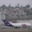

In [3]:
#Load cifar10 dataset
dataset = load_dataset("cifar10")

#Display an image
display(dataset['train'][0]['img'])

## Extracting the features

In [5]:
#Add a vector to FAISS index
def add_vector_to_index(embedding, index):
    #convert embedding to numpy
    vector = embedding.detach().cpu().numpy()
    #Convert to float32 numpy
    vector = np.float32(vector)
    #Normalize vector
    faiss.normalize_L2(vector)
    #Add to index
    index.add(vector)

#Extract features of a given image
def extract_features_clip(image):
    with torch.no_grad():
        inputs = processor(images=image, return_tensors="pt").to(device)
        image_features = model.get_image_features(**inputs)
        return image_features

#Create FAISS index
index = faiss.IndexFlatL2(512)

#Process the dataset to extract all features and store in index
for image in tqdm(dataset['test']):
    clip_features = extract_features_clip(image['img'])
    add_vector_to_index(clip_features,index)

#Write index locally. Not needed after but can be useful for future retrieval
faiss.write_index(index,"clip.index")

100%|██████████| 10000/10000 [02:53<00:00, 57.65it/s]


## Creating 10 clusters

In [7]:
#Retrieve the vectors
vectors = index.reconstruct_n(0, 10000)

#Define clusters and parameters
x= vectors
ncentroids = 10
niter = 50
verbose = True
d = x.shape[1]

import time
t0=time.time()
#Launch clustering
kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose)
kmeans.train(x)
print('Clustering done in ', time.time()-t0)

#cluster assignments: [array of vectors, array of indices (cluster assigned to a given vector)]
cluster_assignments = kmeans.assign(vectors)
print(cluster_assignments)
#Print indices only
clusters_ind = cluster_assignments[1]
print(clusters_ind)

Clustering done in  0.3226318359375
(array([0.12448764, 0.16233206, 0.15056908, ..., 0.13251746, 0.24733269,
       0.14068532], dtype=float32), array([4, 8, 8, ..., 6, 7, 2]))
[4 8 8 ... 6 7 2]


## Creating the distribution matrix

[[  0   0   0  35   1 697   1   0   0   0]
 [  0   0 140  11 869   2   0  13   0   0]
 [  0   0   0   1   8   4   0 920   0   0]
 [939   0   3   0   0   0   0   0   9   0]
 [ 52   6 291  86 107  40 182  59  32   9]
 [  0   0 555   0   5   0   4   0   0   0]
 [  0   0   8 853   4 256  12   8   0   0]
 [  1 994   0   2   0   0   0   0   0 988]
 [  8   0   1   0   0   0   0   0 959   3]
 [  0   0   2  12   6   1 801   0   0   0]]


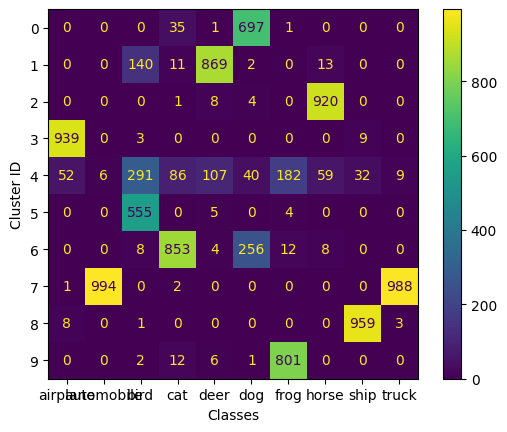

In [8]:
distribution = np.zeros((10, 10), dtype=int)

for vector_index,cluster_nb in enumerate(clusters_ind):
    label = dataset['test'][vector_index]['label']
    distribution[cluster_nb][label]+=1

print(distribution)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=distribution)
disp.plot()
plt.ylabel('Cluster ID')
plt.xlabel('Classes')
labels = dataset["train"].features["label"].names
x = range(len(labels))
ticks = labels
plt.xticks(x, ticks)
plt.show()